The next cell is to check if GPU is available in your environment.

In [2]:
import sys
import torch

print(sys.executable)
print(torch.__file__)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


/home/bhtran/repo/Super-Resolution/.venv/bin/python
/home/bhtran/repo/Super-Resolution/.venv/lib/python3.12/site-packages/torch/__init__.py
2.9.1+cu126
12.6
True


In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.auto import tqdm

### Data loading
We will create a custom dataset class for loading our images. This class will inherit from `torch.utils.data.Dataset` and implement the necessary methods to load and preprocess the images (and maybe data augmentation in the future).

In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, npz_file_path):
        """Load tensors from .npz file"""
        data = np.load(npz_file_path)
        self.hr_images = data['hr']
        self.lr_images = data['lr']

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        #Because the image dimension is (batch, height, width, channels) 
        #So i do a permutation here to (C,H,W) to fit the model
        lr = torch.from_numpy(self.lr_images[idx]).permute(2, 0, 1)
        hr = torch.from_numpy(self.hr_images[idx]).permute(2, 0, 1)

        return lr, hr

training_dataset = SuperResolutionDataset('../data/hr_lr_images.npz')
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

### Data Split
Split the dataset into training and validation sets to evaluate model performance during training.

In [5]:
from torch.utils.data import random_split

# Split dataset into training (80%), validation (15%), and test (5%)
train_size = int(0.8 * len(training_dataset))
val_size = int(0.15 * len(training_dataset))
test_size = len(training_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(training_dataset, [train_size, val_size, test_size])

# Create dataloaders for training, validation, and test
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Training samples: 13883
Validation samples: 2603
Test samples: 868


In [6]:
import sys
sys.path.insert(0, '..')
from src.model import SuperResolutionModel

The line below just a sanitty check to ensure that our model is working as expected. Sometimes notebooks environments are populated.

In [7]:
model = SuperResolutionModel()
x = torch.randn(1, 3, 32, 32)
y = model(x)
print(type(y))
print(y.shape)

<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])


### Check your model shape and size
The model should not exceed 5 million parameters.

In [8]:
# device refers to the GPU or the CPU, depending whether GPU is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = SuperResolutionModel().to(device)

# display information about the model
summary(model, (3,32,32))

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters:', params)
if params > 5_000_000:
    raise Exception('Your model is unecessarily complex, scale down!')

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 48, 32, 32]          27,696
      PixelShuffle-6          [-1, 3, 128, 128]               0
Total params: 69,488
Trainable params: 69,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.75
Params size (MB): 0.27
Estimated Total Size (MB): 3.03
----------------------------------------------------------------
Trainable parameters: 69488
----------------------------------------------------------------
        Layer (type)               Output Shape         Para

### Plot setup and Hyperparameters 

In [14]:
# Custom callback for plotting loss and accuracy during training
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output


class PlotLogAccuracy:

  def __init__(self):
    self.epochs = []
    self.train_losses = []
    self.val_losses = []
    self.train_acc = []
    self.val_acc = []
    self.epoch_count = 0

  def update(self, train_loss, train_acc, val_loss, val_acc):
    self.epochs.append(self.epoch_count)
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_count += 1

    clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(self.epochs, self.train_losses, label="train loss")
    plt.plot(self.epochs, self.val_losses, label="validation loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(self.epochs, self.train_acc, label="training accuracy")
    plt.plot(self.epochs, self.val_acc, label="validation accuracy")
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show();

plotter = PlotLogAccuracy()

In [21]:
epochs = 50
batch_size = 64
learning_rate = 0.005
momentum = 0.9

criterion = nn.MSELoss()

# setting the model (calling this again will reset the weights)
model = SuperResolutionModel().to(device)

# play with this
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=torch.cuda.is_available())
valloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=torch.cuda.is_available())

train_loss_hist, val_loss_hist = [], []

print('Setup complete.')

Setup complete.


This is psnr validation metric

In [19]:
def psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    return 10 * torch.log10(1.0 / mse)

In [22]:
print('Starting training...')

# Epoch Loop: It iterates through the specified number of training epochs.

for epoch in range(epochs):

    # For each epoch, all data in the dataset is processed.

    model.train() # Sets the model to training mode

    running_loss = 0.0 # resetting loss metric

    #  Iterates through the `trainloader` to get mini-batches of data
    for x_batch, y_batch in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False):

        # copying data to the GPU (the `device`) if GPU is available
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()           # setting up gradient to zero
        out = model(x_batch)            # Performs the forward pass
        loss = criterion(out, y_batch)  # calculates the loss
        loss.backward()                 # performs backpropagation in parallel on the batch
        optimizer.step()                # optimizer steps to update the model's weights

        # updating current training loss on the mini-batch
        running_loss += loss.item() * x_batch.size(0)

    train_loss = running_loss / len(trainloader.dataset)

    # Computing Validation Loss

    model.eval() # switching model to eval mode, disabling dropout/batchnorm/other custom modules
    val_running_loss = 0.0
    val_psnr = 0.0
    with torch.no_grad(): # we disable gradient computation to save some memory
        for x_batch, y_batch in tqdm(valloader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_running_loss += loss.item() * x_batch.size(0)
            val_psnr += psnr(out, y_batch).item()
    val_loss = val_running_loss / len(valloader.dataset)
    val_psnr /= len(valloader)

    # scheduler.step()

    # Record training loss
    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)

    # Print loss for training/validation
    print(
        f'Epoch {epoch+1}: '
        f'Train Loss {train_loss:.4f} | '
        f'Val Loss {val_loss:.4f} | '
        f'Val PSNR {val_psnr:.2f} dB'
    )

print('Training finished.')


Starting training...


Epoch 1/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.0644 | Val Loss 0.0288 | Val PSNR 15.41 dB


Epoch 2/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2: Train Loss 0.0267 | Val Loss 0.0235 | Val PSNR 16.29 dB


Epoch 3/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3: Train Loss 0.0212 | Val Loss 0.0185 | Val PSNR 17.34 dB


Epoch 4/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4: Train Loss 0.0169 | Val Loss 0.0153 | Val PSNR 18.15 dB


Epoch 5/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5: Train Loss 0.0145 | Val Loss 0.0137 | Val PSNR 18.64 dB


Epoch 6/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6: Train Loss 0.0133 | Val Loss 0.0129 | Val PSNR 18.91 dB


Epoch 7/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7: Train Loss 0.0127 | Val Loss 0.0124 | Val PSNR 19.09 dB


Epoch 8/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8: Train Loss 0.0122 | Val Loss 0.0120 | Val PSNR 19.24 dB


Epoch 9/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9: Train Loss 0.0118 | Val Loss 0.0116 | Val PSNR 19.38 dB


Epoch 10/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10: Train Loss 0.0114 | Val Loss 0.0112 | Val PSNR 19.52 dB


Epoch 11/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11: Train Loss 0.0110 | Val Loss 0.0109 | Val PSNR 19.66 dB


Epoch 12/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12: Train Loss 0.0107 | Val Loss 0.0105 | Val PSNR 19.80 dB


Epoch 13/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13: Train Loss 0.0104 | Val Loss 0.0102 | Val PSNR 19.93 dB


Epoch 14/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14: Train Loss 0.0100 | Val Loss 0.0099 | Val PSNR 20.05 dB


Epoch 15/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15: Train Loss 0.0098 | Val Loss 0.0096 | Val PSNR 20.18 dB


Epoch 16/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16: Train Loss 0.0095 | Val Loss 0.0094 | Val PSNR 20.29 dB


Epoch 17/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17: Train Loss 0.0092 | Val Loss 0.0092 | Val PSNR 20.40 dB


Epoch 18/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18: Train Loss 0.0090 | Val Loss 0.0089 | Val PSNR 20.50 dB


Epoch 19/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19: Train Loss 0.0088 | Val Loss 0.0088 | Val PSNR 20.60 dB


Epoch 20/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20: Train Loss 0.0086 | Val Loss 0.0086 | Val PSNR 20.69 dB


Epoch 21/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21: Train Loss 0.0084 | Val Loss 0.0084 | Val PSNR 20.77 dB


Epoch 22/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22: Train Loss 0.0083 | Val Loss 0.0083 | Val PSNR 20.84 dB


Epoch 23/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23: Train Loss 0.0081 | Val Loss 0.0081 | Val PSNR 20.92 dB


Epoch 24/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24: Train Loss 0.0080 | Val Loss 0.0080 | Val PSNR 20.98 dB


Epoch 25/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25: Train Loss 0.0079 | Val Loss 0.0079 | Val PSNR 21.05 dB


Epoch 26/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26: Train Loss 0.0078 | Val Loss 0.0078 | Val PSNR 21.10 dB


Epoch 27/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27: Train Loss 0.0077 | Val Loss 0.0077 | Val PSNR 21.16 dB


Epoch 28/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28: Train Loss 0.0076 | Val Loss 0.0076 | Val PSNR 21.21 dB


Epoch 29/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29: Train Loss 0.0075 | Val Loss 0.0075 | Val PSNR 21.25 dB


Epoch 30/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30: Train Loss 0.0074 | Val Loss 0.0075 | Val PSNR 21.29 dB


Epoch 31/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31: Train Loss 0.0073 | Val Loss 0.0074 | Val PSNR 21.33 dB


Epoch 32/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32: Train Loss 0.0073 | Val Loss 0.0073 | Val PSNR 21.37 dB


Epoch 33/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 33: Train Loss 0.0072 | Val Loss 0.0073 | Val PSNR 21.40 dB


Epoch 34/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34: Train Loss 0.0071 | Val Loss 0.0072 | Val PSNR 21.44 dB


Epoch 35/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35: Train Loss 0.0071 | Val Loss 0.0072 | Val PSNR 21.47 dB


Epoch 36/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 36: Train Loss 0.0070 | Val Loss 0.0071 | Val PSNR 21.50 dB


Epoch 37/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37: Train Loss 0.0070 | Val Loss 0.0071 | Val PSNR 21.52 dB


Epoch 38/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 38: Train Loss 0.0070 | Val Loss 0.0070 | Val PSNR 21.55 dB


Epoch 39/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39: Train Loss 0.0069 | Val Loss 0.0070 | Val PSNR 21.58 dB


Epoch 40/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40: Train Loss 0.0069 | Val Loss 0.0069 | Val PSNR 21.60 dB


Epoch 41/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 41: Train Loss 0.0068 | Val Loss 0.0069 | Val PSNR 21.63 dB


Epoch 42/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42: Train Loss 0.0068 | Val Loss 0.0069 | Val PSNR 21.65 dB


Epoch 43/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 43: Train Loss 0.0068 | Val Loss 0.0068 | Val PSNR 21.67 dB


Epoch 44/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44: Train Loss 0.0067 | Val Loss 0.0068 | Val PSNR 21.69 dB


Epoch 45/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 45: Train Loss 0.0067 | Val Loss 0.0068 | Val PSNR 21.71 dB


Epoch 46/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46: Train Loss 0.0067 | Val Loss 0.0067 | Val PSNR 21.73 dB


Epoch 47/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47: Train Loss 0.0066 | Val Loss 0.0067 | Val PSNR 21.75 dB


Epoch 48/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 48: Train Loss 0.0066 | Val Loss 0.0067 | Val PSNR 21.77 dB


Epoch 49/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49: Train Loss 0.0066 | Val Loss 0.0067 | Val PSNR 21.79 dB


Epoch 50/50 [Train]:   0%|          | 0/217 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 50: Train Loss 0.0065 | Val Loss 0.0066 | Val PSNR 21.81 dB
Training finished.


As ChatGPT says, good PSNR values typically range from 30 dB to 50 dB for high-quality images, with higher values indicating better quality.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0046646018..0.9483334].


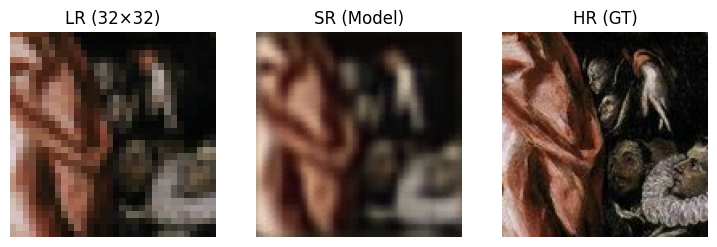

In [ ]:
import matplotlib.pyplot as plt
import cv2

model.eval()
with torch.no_grad():
    lr, hr = val_dataset[1]
    lr = lr.unsqueeze(0).to(device)
    sr = model(lr).cpu().squeeze(0)

# Convert CHW → HWC
lr = lr.cpu().squeeze(0).permute(1, 2, 0)
sr = sr.permute(1, 2, 0)
hr = hr.permute(1, 2, 0)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.title("LR (32×32)")
plt.imshow(lr)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("SR (Model)")
plt.imshow(sr)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("HR (GT)")
plt.imshow(hr)
plt.axis("off")

plt.show()
